In [0]:
from pyspark.sql import *
import pandas as pd
import numpy as np
import gc
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
from lifelines import CoxPHFitter
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib
print(matplotlib.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta , date ,datetime
%matplotlib inline
import pickle
import calendar
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70
%config InlineBackend.figure_format = 'retina'

path_model = '/dbfs/FileStore/Churn Analysis/'

3.2.2

In [0]:
### Create ChildStage From Fuction
## Function Segmentation
def child_stage(data):
  if data["ChildStage_month"] < 0:
    return "Pregnant"
  if data["ChildStage_month"] <= 6:
    return "0-6 month"
  if data["ChildStage_month"] <= 12:
    return "7-12 month"
  if data["ChildStage_month"] <= 36:
    return "1-3 year"
  if data["ChildStage_month"] <= 72:
    return "3-6 year"
  if data["ChildStage_month"] > 72:
    return "6 year ++"
  else:
    return "None"

#Step1 : Load Data For Exploration

In [0]:
end_date_train = '2021-01-01'
version = 1  #version config

In [0]:
## Path 1 Load Data Login
user_login_f = usl_spark.select("*").toPandas()
user_login_f = user_login_f[user_login_f['logindate'] < end_date_train ]  ## Config Param here

## 2. Get  User

user_profile =  uspf_spark.select("*").toPandas()

##3 . Get Payment  Transaction
## 3.1 Scaling Transaction Between 2019-2020

user_payment_1 = user_payment[[columns]] ## Hide columns


history =  cphty_spark.select("*").toPandas()
history = history[(history['useddate'] < end_date_train)]

user_payment_item_detail = pmdtit_spark.select("*").toPandas()

trade_data = trade_spark.select("*").toPandas()

#Step2 : Preparation Data

### Step 2.1 Calculate User Churn and Not Churn 
### **From Active User Not more than 90 Days is not Churn and Active Since 90 Days is Churn

In [0]:
## Finding Last Login(Active) User
user_login_1 = user_login_f.groupby(['id'],as_index=False)\
                         .agg({'logindate':max})\
                         .rename(columns={'logindate':'last_logindate'})

user_login_1['current_date'] = (pd.to_datetime(end_date_train) - timedelta(days =1)).strftime('%Y-%m-%d')
user_login_1['current_date'] = pd.to_datetime(user_login_1['current_date'])

## Aggregate day Active User 
user_login_1['day_active'] = user_login_1['current_date'].sub(user_login_1['last_logindate'])
user_login_1['day_active'] = user_login_1['day_active']/np.timedelta64(1,'D')    

## Mapping Feature Attribute  OS and Platform 
user_login_1 = user_login_1.merge(user_login_f[['id',
                                                'logindate','os','platform']]\
                                  .rename(columns={'logindate':'last_logindate'}) ,
                                  on=['id','last_logindate'] , how='left')
## Handle Null
user_login_1['os'] = user_login_1['os'].fillna('No_os')
user_login_1['platform'] = user_login_1['platform'].replace(r'^\s*$', np.nan, regex=True)
user_login_1['platform'] = user_login_1['platform'].fillna('No_platform')


## Create User Churn and Not Churn (ตอนนี้ Assume ว่า ถ้าไม่เข้ามาใน 1 ปี ถือว่าเป็น Churn)
user_login_1.loc[user_login_1['day_active'] > 90,'Churn'] = 1
user_login_1.loc[user_login_1['day_active'] <= 90 ,'Churn'] = 0

## Mapping Profile Customer
res_profile = user_login_1.merge(user_profile.rename(columns={'partitionkey':'id'}) , on='id')

## Handle Gender Null Data to 'Not_Specified'
res_profile['gender'] = res_profile['gender'].fillna('Not_Specified')

## drop Columns Not Use
res_profile_2 = res_profile.drop(columns=[])

## Calculate Member Age

#dt = datetime.now().date()
#dt = pd.to_datetime('2020-12-31').date()
dt = (pd.to_datetime(end_date_train) - timedelta(days =1)).date()
res_profile_2['registerdate'] = pd.to_datetime(res_profile_2['registerdate']).dt.strftime('%Y-%m-%d')
res_profile_2['member_age'] = (dt - pd.to_datetime(res_profile_2['registerdate']).dt.date)
res_profile_2['member_age'] = res_profile_2['member_age'] / np.timedelta64(1, 'D')
res_profile_2 = res_profile_2[~res_profile_2['registerdate'].isnull()] ## ตัดคนที่ไม่มี registerdate  ทิ้ง
res_profile_2 = res_profile_2.drop(columns=['childstage']).reset_index(drop=True)  
res_profile_2

In [0]:
del user_login_1
del res_profile
gc.collect()

Out[6]: 130

### Step 2.2 Calculate Feature Frequency Login

In [0]:
df_frequency_login = user_login_f.copy()
df_frequency_login['year_month'] = df_frequency_login['logindate'].dt.strftime('%Y-%m')

df_frequency_login_1 = df_frequency_login.sort_values(['id','year_month'])\
                                         .groupby(['id','year_month'],as_index=False)\
                                         .agg({'logindate':'count'})\
                                         .rename(columns={'logindate':'Frequency_login'})
df_frequency_login_2 = df_frequency_login_1.groupby('id').tail(3)
df_frequency_login_2['month'] = pd.to_datetime(df_frequency_login_2['year_month']).dt.month
df_frequency_login_2['Month_name'] = df_frequency_login_2['month'].apply(lambda x: calendar.month_abbr[x])
df_frequency_login_3 = df_frequency_login_2.groupby(['id','Month_name'],as_index=False).agg({'Frequency_login':'mean'}).pivot(index='id', columns='Month_name', values='Frequency_login').fillna(0).reset_index()
df_frequency_login_3.columns = ['AVG_Frequency_login_' + str(i) if str(i) not in ['id'] else str(i) for ix, i in enumerate(df_frequency_login_3.columns)]

##  Calculate AVG Precentage
df_avg_= df_frequency_login_2.rename(columns={'Frequency_login':'Frequency_login_M0'})
df_avg_pct_change = df_avg_.set_index('year_month').groupby('id')['Frequency_login_M0'].apply(lambda x: x.pct_change().mean()).reset_index().fillna(0)


df_frequency_login_3 = df_frequency_login_3.merge(df_avg_pct_change,on='id',how='left').rename(columns={'Frequency_login_M0':'AVG_Percentage_login_Trend3M'})
df_frequency_login_3

In [0]:
## Merge
res_profile_2 = res_profile_2.merge(df_frequency_login_3,on='id',how='left')
res_profile_2

In [0]:
del df_frequency_login
del df_frequency_login_1
del df_frequency_login_2
del df_frequency_login_3
gc.collect()

Out[9]: 373

### Step 2.3 Calculate Feature insight sale transaction

In [0]:
## 1. <aping payment Discription from paymentdetail
user_payment_2 = user_payment_1.merge(user_payment_item_detail.drop(columns=[...]) , 
                                     on='TranId' , how='left')

trade_data['TranAmount'] = trade_data['TranAmount'].astype(int)
user_payment_2 = user_payment_2[user_payment_2['SuccessDate'] < end_date_train]
user_payment_2['TranAmount'] = user_payment_2['TranAmount'].astype(int)
user_payment_2['Amount'] = user_payment_2['Amount'].astype(int)



### 2.Feature Flag_TransAmount

user_abadon_trade = trade_data[trade_data['Status'] == 0].groupby(['id'],as_index=False)\
                                      .agg({"TranAmount":'sum'})\
                                      .rename(columns={'TranAmount':'FLAG_TRADE_ABANDON_TranAmount'})
                                                                    
user_trade =   trade_data[trade_data['Status'].isin([3,5])].groupby(['id'],as_index=False)\
                                                                .agg({"TranAmount":'sum'})\
                                                                .rename(columns={'TranAmount':'FLAG_TRADE_PAYS_TranAmount'})

user_flag_trade  = user_abadon_trade.merge(user_trade,on='id',how='outer').fillna(0)   
## 3. Feature Flag_Buy Type  


user_abadon_pay = user_payment_2[(user_payment_2['Flag_Payment'] != 'Trade')
                                 & (user_payment_2['Status'] == 0)].groupby(['id'],as_index=False)\
                                                                  .agg({"Amount":'sum'})\
                                                                  .rename(columns={'Amount':'FLAG_BUY_ABANDON_TranAmount'})
                                                                    
user_pay = user_payment_2[(user_payment_2['Flag_Payment'] != 'Trade')
                               & (user_payment_2['Status'].isin([3,5]))].groupby(['id'],as_index=False)\
                                                                .agg({"Amount":'sum'})\
                                                                .rename(columns={'Amount':'FLAG_BUY_PAYS_TranAmount'})

user_flag_buy = user_abadon_pay.merge(user_pay,on='id',how='outer').fillna(0)   

## Mapping Feature Abandon and Success Payment
res_user_pay_amount = user_flag_buy.merge(user_flag_trade,on='id',how='outer').fillna(0)
res_user_pay_amount

In [0]:
res_profile_2_1 = res_profile_2.merge(res_user_pay_amount , on='id' , how='left').fillna(0)
res_profile_2_1

In [0]:
del user_flag_buy
del user_flag_trade
del res_user_pay_amount
gc.collect()

Out[12]: 233

###Step 2.4 Calculate Feature Offline Payment Use Point

In [0]:
## Aggragate 
history_prep = history_prep.groupby(['id'],as_index=False)\
                                      .agg({'rowkey':'nunique' ,'points':sum})                            

In [0]:
res_profile_2_1 = res_profile_2_1.merge(history_prep , on='id' , how='left').fillna(0)
res_profile_2_1

##Step 2.5 Calculate Feature ส่วนลดที่ได้เฉลี่ยของแต่ละคน

In [0]:
user_payment_dis = user_payment_2.copy()
user_payment_dis['Discount'] = user_payment_dis['Discount'].astype(float)
user_payment_dis = user_payment_dis.iloc[:,:14]
user_payment_dis = user_payment_dis.drop_duplicates()
user_payment_dis_1 = user_payment_dis.groupby(['id','TranId'],as_index=False)\
                              .agg({'Discount':'sum'})\
                              .groupby(['id'],as_index=False)\
                              .agg({'Discount':'mean'}).sort_values(by='Discount')\
                              .rename(columns={'Discount':'AVG_DISCOUNT'})
user_payment_dis_1

In [0]:
res_profile_2_2 = res_profile_2_1.merge(user_payment_dis_1,on='id' , how='left').fillna(0)
res_profile_2_2

##Step 2.6 Calculate Feature เกี่ยวกับตัวสินค้า เช่น Basket Size

In [0]:
user_payment_item_detail_prep = user_payment_item_detail[~user_payment_item_detail['SuccessDate'].isnull()]
user_payment_item_detail_prep['PricePerUnit'] = user_payment_item_detail_prep['PricePerUnit'].astype(int)
user_payment_item_detail_prep = user_payment_item_detail_prep[user_payment_item_detail_prep['Flag_Payment'] =='Buy']
## Feature AVG ITEM Buy Transaction Per USER
user_payment_item_detail_prep_avg_item = user_payment_item_detail_prep.groupby(['id','TranId'],as_index=False)\
                                                                      .agg({'TranItemId':'count'})\
                                                                      .sort_values(by='TranItemId')
user_payment_item_detail_prep_avg_item = user_payment_item_detail_prep_avg_item.groupby(['id'],as_index=False)\
                                                                      .agg({'TranItemId':'mean'})\
                                                                      .rename(columns={'TranItemId':'AVG_ITEM_PER_TRANS'})
## Feature AVG PRICE Buy Transaction Per USER
user_payment_item_detail_prep_avg = user_payment_item_detail_prep.groupby(['id','TranId'] ,as_index=False).agg({"PricePerUnit":sum})\
                                                                              .groupby(['CustomerId'],as_index=False)\
                                                                              .agg({'PricePerUnit':'mean'})\
                                                                              .rename(columns={'PricePerUnit':'AVG_Price_PER_TRANS''CustomerId':'userid'})

In [0]:
res_profile_2_3 = res_profile_2_2.merge(user_payment_item_detail_prep_avg_item , on='id' , how='left')\
               .merge(user_payment_item_detail_prep_avg,on='id',how='left').fillna(0)
res_profile_2_3

In [0]:
del user_payment_item_detail_prep_avg_item
del user_payment_item_detail_prep_avg
gc.collect()

Out[19]: 280

##Step 2.7 Calculate Feature ปริมาณการซื้อเฉลี่ยในแต่ลเดือนของ user

In [0]:
df_quantity_user_0 = user_payment_2.iloc[:,:14]
df_quantity_user_0 = df_quantity_user_0.drop_duplicates()
df_quantity_user_0['year_month'] = df_quantity_user_0['SuccessDate'].dt.strftime('%Y-%m')
df_quantity_user = df_quantity_user_0.groupby(['id','year_month'],as_index=False)\
                                         .agg({"Quantity":'sum'})
df_quantity_user['month'] = pd.to_datetime(df_quantity_user['year_month']).dt.month
df_quantity_user['Month_name'] = df_quantity_user['month'].apply(lambda x: calendar.month_abbr[x])
df_quantity_user_1 = df_quantity_user.groupby(['id','Month_name'] ,as_index=False)\
                                     .agg({'Quantity':'mean'})

df_quantity_user_1_2 = df_quantity_user_1.pivot(index='userid', columns='Month_name', values='Quantity').fillna(0).reset_index()
df_quantity_user_1_2.columns = ['AVG_Quantity_' + str(i) if str(i) not in ['id'] else str(i) for ix, i in enumerate(df_quantity_user_1_2.columns)]


In [0]:
res_profile_2_3 = res_profile_2_3.merge(df_quantity_user_1_2 , on=['id'] , how='left').fillna(0)

In [0]:
del df_quantity_user
del df_quantity_user_1
del df_quantity_user_1_2
gc.collect()

Out[22]: 183

##Step 2.8 Calculate Feature Last Day Purchase (Recency)
- Mapping Offline มาด้วย

In [0]:
df_recency = pd.concat([user_payment_2,history[['id','useddate','points']].drop_duplicates()], axis=0, ignore_index=True)
df_recency['SuccessDate'] = df_recency['SuccessDate'].fillna(value=df_recency[~df_recency['useddate'].isnull()]['useddate'] )
#df_recency = df_recency.drop(columns='SuccessDate_2')
df_recency['SuccessDate_2'] = pd.to_datetime(df_recency['SuccessDate'].dt.strftime('%Y-%m-%d'))
### คำนวณ Recency

#NOW = datetime.now()
NOW_2020 = pd.to_datetime((pd.to_datetime(end_date_train) - timedelta(days =1)).strftime('%Y-%m-%d'))

user_last_tran = df_recency.groupby(['id'] ,as_index=False)\
                            .agg({'SuccessDate_2':lambda x: (NOW_2020 - x.max()).days})\
                            .rename(columns={'SuccessDate_2' : 'Recency'})\
                            .sort_values(by='Recency')
user_last_tran

In [0]:
res_profile_2_4 = res_profile_2_3.merge(user_last_tran, on='id' , how='left')
## Handle User not Recency by get max recency Fillna
res_profile_2_4['Recency'] = res_profile_2_4['Recency'].fillna(res_profile_2_4['Recency'].max()) ###
res_profile_2_4

##Step  2.9 Calculate Feature ChilStage ใหม่ ดังนี้
 - การคำนวณวันคิดได้ดังนี้ ChildStage_day  =  last_purcahse - DateOfbirth
 - last_purchase = วันสุดท้ายที่ user ซื้อ


In [0]:
## Get Last Purchase ของแต่ละคน
df_chilstage = user_payment_2[user_payment_2['Status'].isin([3,5])]

df_chilstage_2 = pd.concat([df_chilstage,history[['id','useddate']].drop_duplicates()], axis=0, ignore_index=True)

## จากนั้น แทนที่ SuccessDate ที่เป็น Null ด้วย Usedate
df_chilstage_2['SuccessDate'] = df_chilstage_2['SuccessDate'].fillna(value=df_chilstage_2[~df_chilstage_2['useddate'].isnull()]['useddate'] )
df_chilstage_2['SuccessDate_2'] = pd.to_datetime(df_chilstage_2['SuccessDate']).dt.strftime('%Y-%m-%d')
## หา Last Purcahse
df_chilstage_2_last_purchase = df_chilstage_2.groupby(['id'])\
                                            .agg({'SuccessDate_2':max})\
                                            .rename(columns={'SuccessDate_2' : 'last_purchase'})\
                                            .reset_index()

df_chilstage_2_last_purchase['last_purchase'] = pd.to_datetime(df_chilstage_2_last_purchase['last_purchase'])
test = df_chilstage_2_last_purchase.merge(user_profile , on=['id']  , how='left' )
test['DateOfBirth'] = pd.to_datetime(test['DateOfBirth'] , errors='coerce')
test['ChildStage_month'] = (test['last_purchase'] - test['DateOfBirth']).dt.days *  (12.0/365.25)
res_profile_2_5 = res_profile_2_4.merge(test.drop(columns=['AddressProvinceName']), on=['id']  , how='left' )
res_profile_2_5 = res_profile_2_5.assign(ChildStage=res_profile_2_5.apply(child_stage, axis=1))
res_profile_2_5

In [0]:
pd.crosstab(res_profile_2_5['ChildStage'] ,'col')

In [0]:
## Save Data Preparation
res_profile_2_5.to_pickle('/dbfs/FileStore/data_prep_result_before_dummies_v'+str(version)+'.data')

In [0]:
## Drop Childstage Null
res_profile_3 = res_profile_2_5[~res_profile_2_5['ChildStage_month'].isnull()]
## Drop out Columns Not Use
res_profile_3_1 = res_profile_3.drop(columns=['last_logindate','current_date','joindate','DateOfBirth','last_purchase','DateOfBirth'])

In [0]:
## ดู Event Rate
pd.crosstab(res_profile_3_1['Churn'] ,'Col')

Out[29]:

col_0,Col
Churn,
0.0,29172
1.0,39328


In [0]:
#res_profile_3_1.groupby('Churn').mean()

##Step 2.10 Plot ดูอัตราการอยู่รอด ก่อนว่า ที่ Confidense Interval = 95% ลูกค้าจะหายไปในกี่วัน คิดเป็นกี่เปอร์เซ็น 

Out[31]:

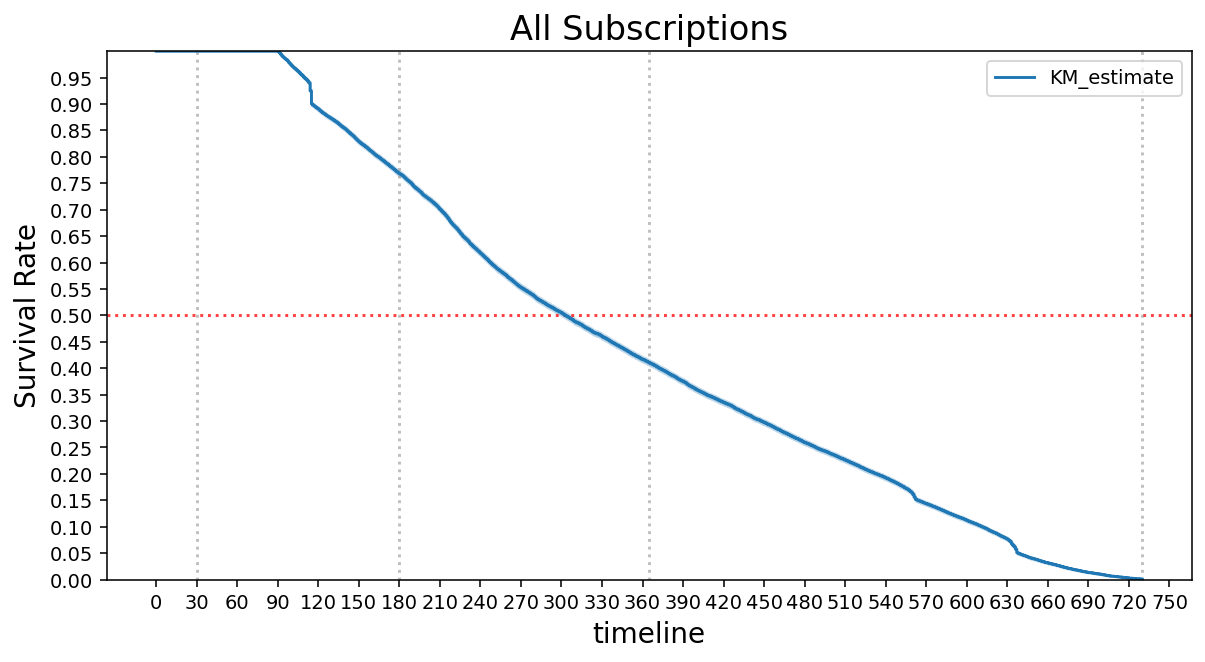

<matplotlib.axes._subplots.AxesSubplot at 0x7fd6ac038af0>

In [0]:
kmf = KaplanMeierFitter(alpha=0.05) # calculate a 95% confidence interval
kmf.fit(res_profile_3_1['day_active'], res_profile_3_1['Churn'])
# plot attributes
plt.figure(figsize=(10,5))
plt.title('All Subscriptions', fontsize='xx-large')

# y-axis
plt.ylabel('Survival Rate', fontsize='x-large')
plt.ylim((0.0, 1.0))
plt.yticks(np.arange(0.0,1.0,0.05))
plt.axhline(0.5, color='red', alpha=0.75, linestyle=':') # median line in red

# x-axis
plt.xlabel('Timeline (Days)', fontsize='x-large')
plt.xticks(range(0,800,30))
plt.axvline(30, color='gray', alpha=0.5, linestyle=':')  # 30-day gray dashed line
plt.axvline(180, color='gray', alpha=0.5, linestyle=':')  # 30-day gray dashed line
plt.axvline(365, color='gray', alpha=0.5, linestyle=':') # 1-year gray dashed line
plt.axvline(365*2, color='gray', alpha=0.5, linestyle=':') # 2-year gray dashed line

kmf.plot_survival_function()

0-6 month: 150.000000
1-3 year: 169.000000
3-6 year: 107.000000
6 year ++: 115.000000
7-12 month: 197.000000
Pregnant: 154.000000

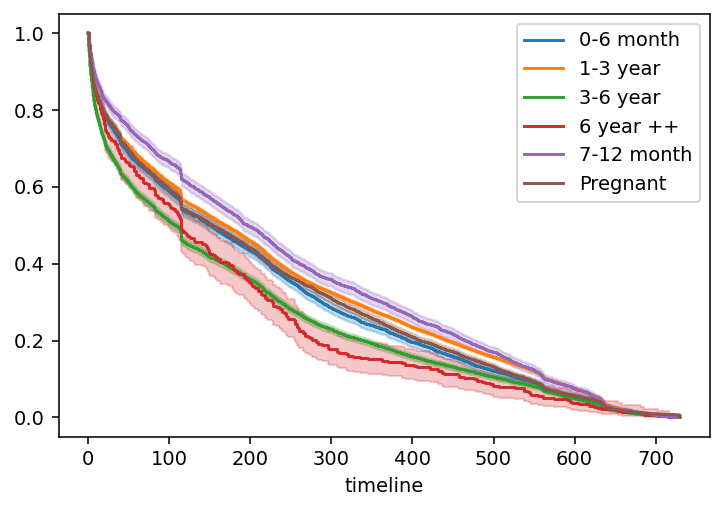

In [0]:
Time = res_profile_3_1['day_active']
Event = res_profile_3_1['Churn']
CHILSTAGE_OVER_0= res_profile_3_1['ChildStage'] == '0-6 month'
CHILSTAGE_OVER_1 = res_profile_3_1['ChildStage'] == '1-3 year'
CHILSTAGE_OVER_2 = res_profile_3_1['ChildStage'] == '3-6 year'
CHILSTAGE_OVER_3 = res_profile_3_1['ChildStage'] == '6 year ++'
CHILSTAGE_OVER_4 = res_profile_3_1['ChildStage'] == '7-12 month'
CHILSTAGE_OVER_5 = res_profile_3_1['ChildStage'] == 'Pregnant'
kmf.fit(Time[CHILSTAGE_OVER_0], event_observed = Time[CHILSTAGE_OVER_0], label = '0-6 month')
print('0-6 month: %f'%kmf.median_survival_time_)
ax = kmf.plot()

kmf.fit(Time[CHILSTAGE_OVER_1], event_observed = Time[CHILSTAGE_OVER_1], label = '1-3 year')
print('1-3 year: %f'%kmf.median_survival_time_)
ax = kmf.plot(ax = ax)

kmf.fit(Time[CHILSTAGE_OVER_2], event_observed = Time[CHILSTAGE_OVER_2], label = '3-6 year')
print('3-6 year: %f'%kmf.median_survival_time_)
ax = kmf.plot(ax = ax)

kmf.fit(Time[CHILSTAGE_OVER_3], event_observed = Time[CHILSTAGE_OVER_3], label = '6 year ++')
print('6 year ++: %f'%kmf.median_survival_time_)
ax = kmf.plot()

kmf.fit(Time[CHILSTAGE_OVER_4], event_observed = Time[CHILSTAGE_OVER_4], label = '7-12 month')
print('7-12 month: %f'%kmf.median_survival_time_)
ax = kmf.plot(ax = ax)

kmf.fit(Time[CHILSTAGE_OVER_5], event_observed = Time[CHILSTAGE_OVER_5], label = 'Pregnant')
print('Pregnant: %f'%kmf.median_survival_time_)
ax = kmf.plot(ax = ax)


## Step 2.11 Label Encoder

In [0]:
## For Model
data_num2 = res_profile_3_1._get_numeric_data()
category2 = pd.get_dummies(res_profile_3_1[['gender','ChildStage']]) 

### Check Feature Correrate

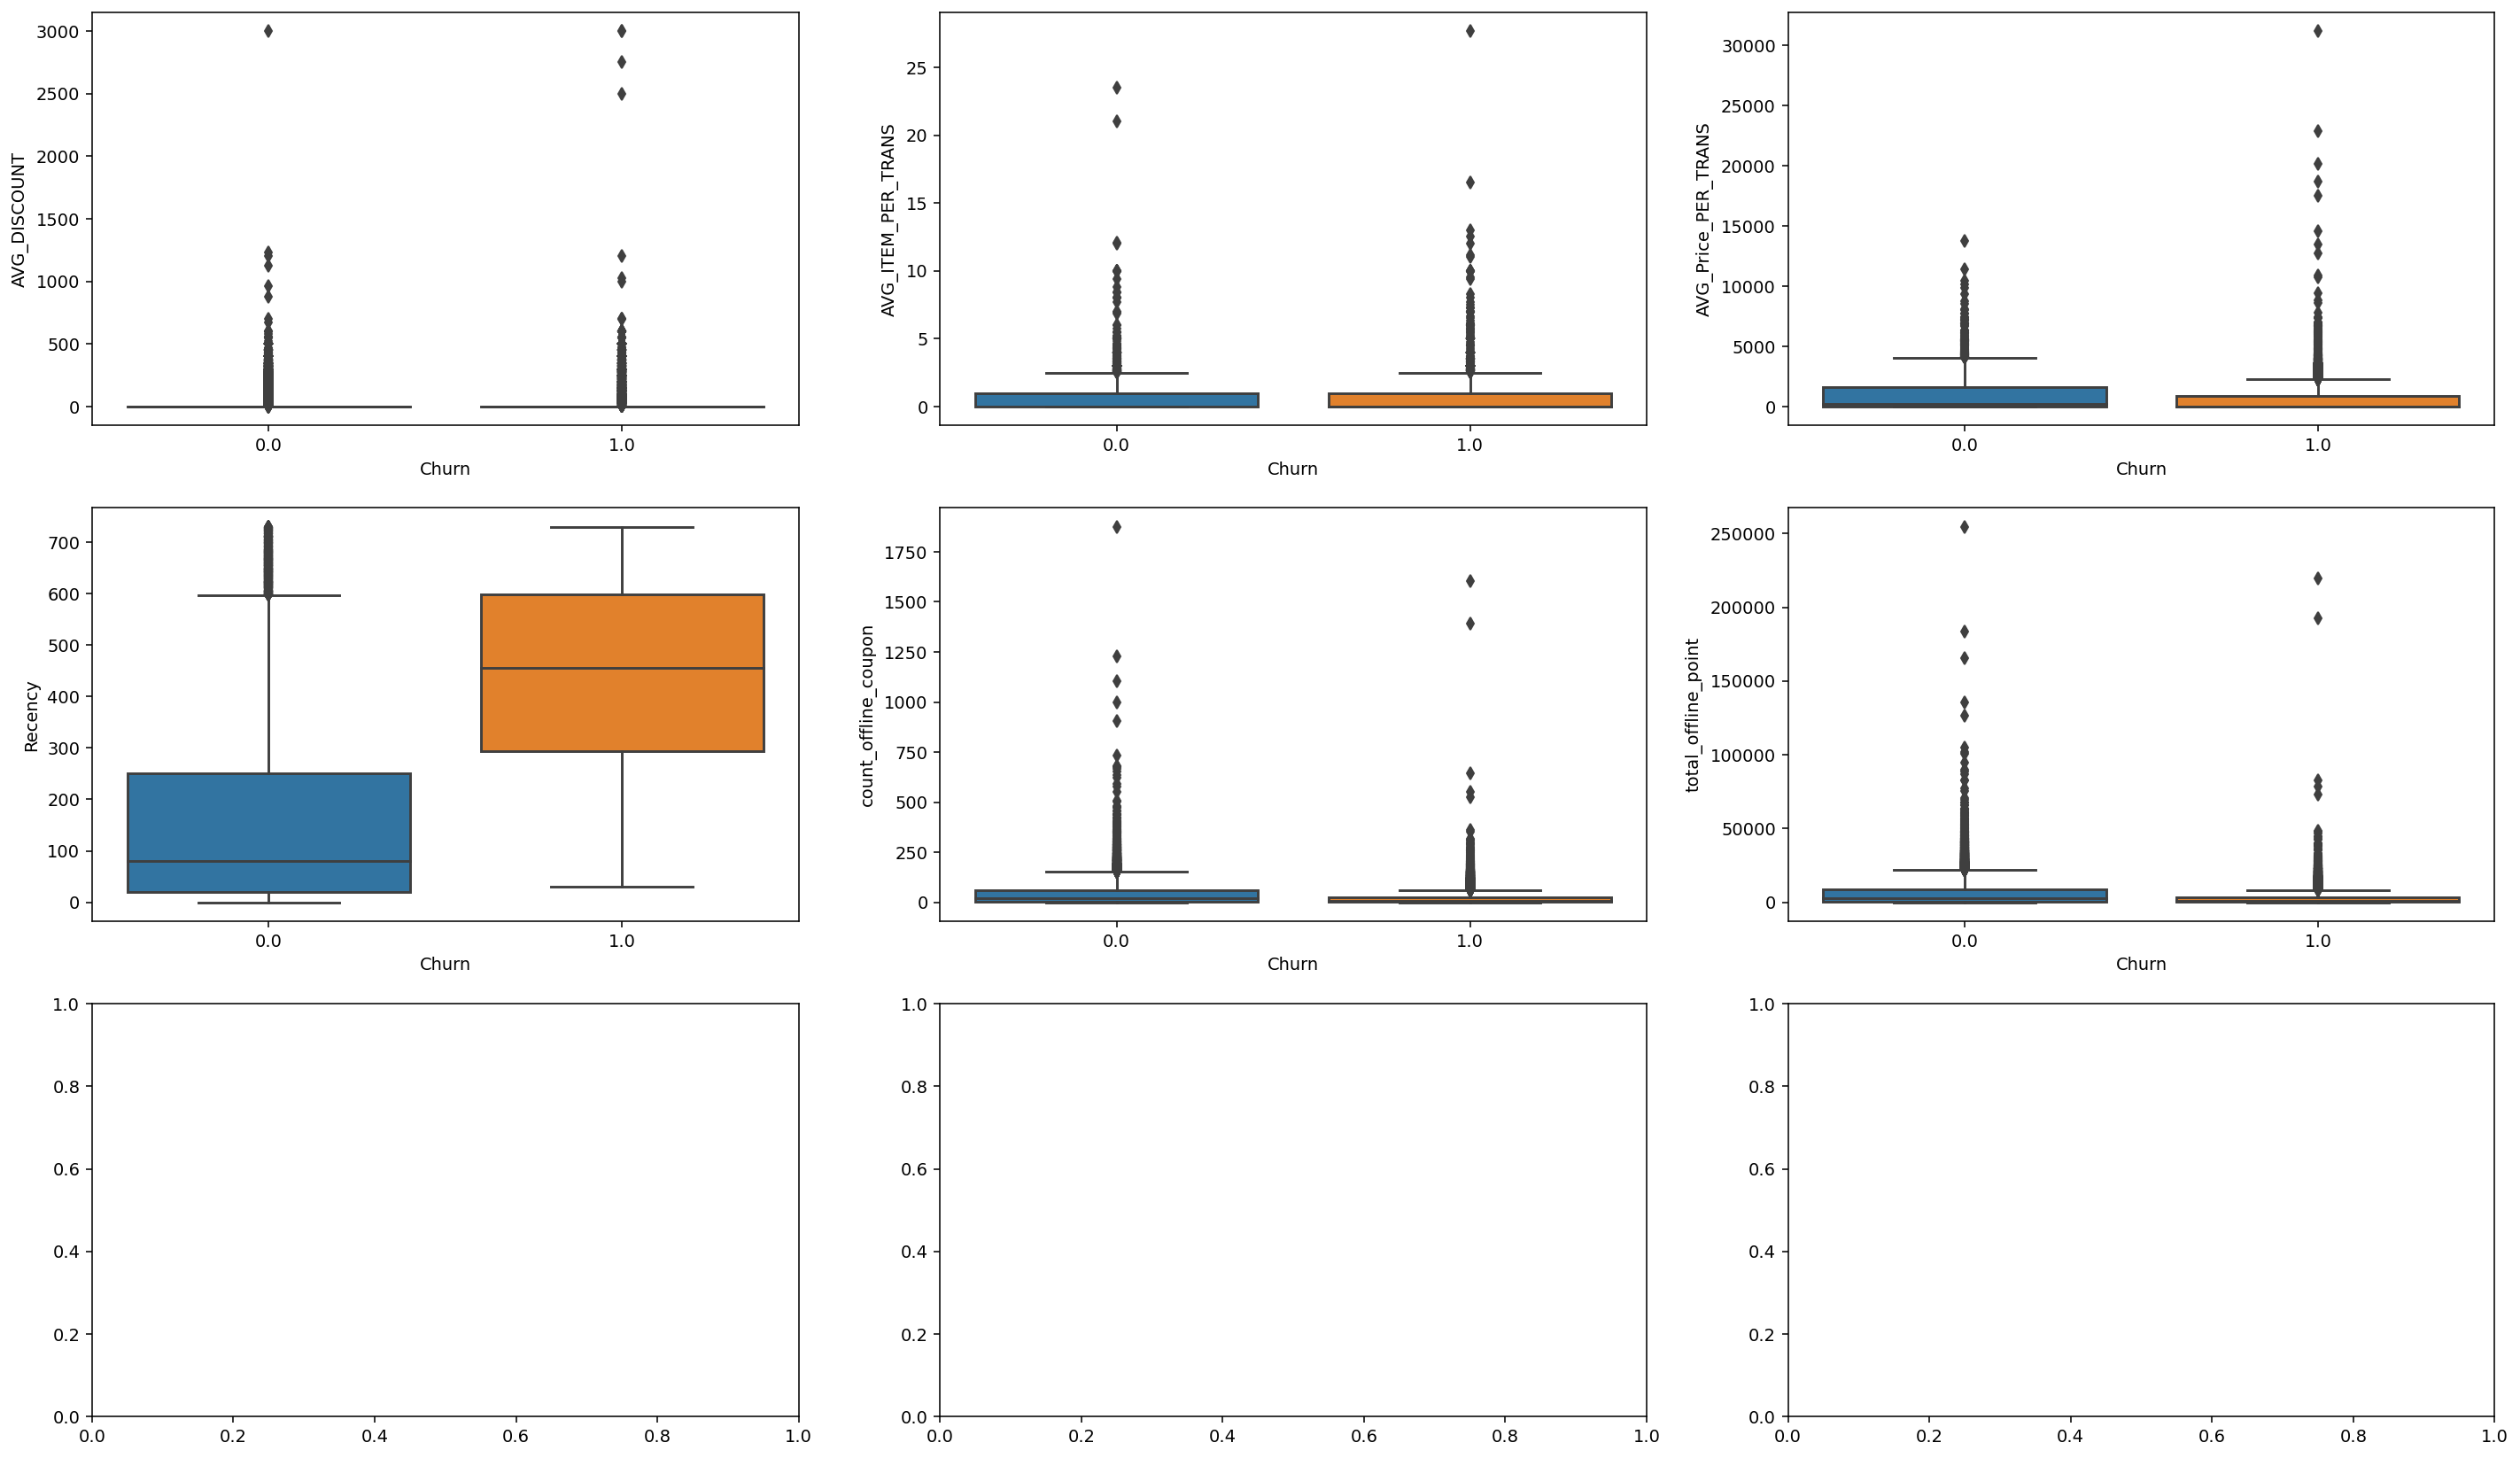

In [0]:
test = data_num2.copy()
res_val = test['Churn']
other = ['AVG_DISCOUNT','AVG_ITEM_PER_TRANS','AVG_Price_PER_TRANS','Recency','count_offline_coupon','total_offline_point']
freq_login = data_num2.columns[data_num2.columns.str.contains('login')]
frag_type = data_num2.columns[data_num2.columns.str.startswith('FLAG')]
avg_quan = data_num2.columns[data_num2.columns.str.startswith('AVG_Quantity')]
def plot_Correlation(test,res_val):
  num_row_dims = int(test.shape[1]/3) +1
  dims = (num_row_dims, 3)
  f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
  axis_i, axis_j = 0, 0
  for col in test.columns:
    if col == 'Churn' :
      continue # Box plots cannot be used on indicator variables
    sns.boxplot(x=res_val, y=test[col], ax=axes[axis_i, axis_j])
    axis_j += 1
    if axis_j == dims[1]:
      axis_i += 1
      axis_j = 0

test2 = test.copy()
test2 = test2[other]
plot_Correlation(test2,res_val)

#Step4 :  Build Model For Predict 

#### 4.1 Train Test Split

In [0]:
data_num2 = data_num2.reset_index(drop=True)
category2 = category2.reset_index(drop=True)
res_profile_3_1 = res_profile_3_1.reset_index(drop=True)
itemData_final_for_model = pd.concat([data_num2,category2] ,axis=1)
itemData_final_2 = pd.merge(res_profile_3_1[['id']], itemData_final_for_model, left_index=True, right_index=True)
itemData_final_2

In [0]:
itemData_final = pd.concat([data_num2.drop(columns=['FLAG_BUY_ABANDON_TranAmount']),pd.get_dummies(res_profile_3_1[['gender','ChildStage']],drop_first=True) ] ,axis=1)

Out[75]:

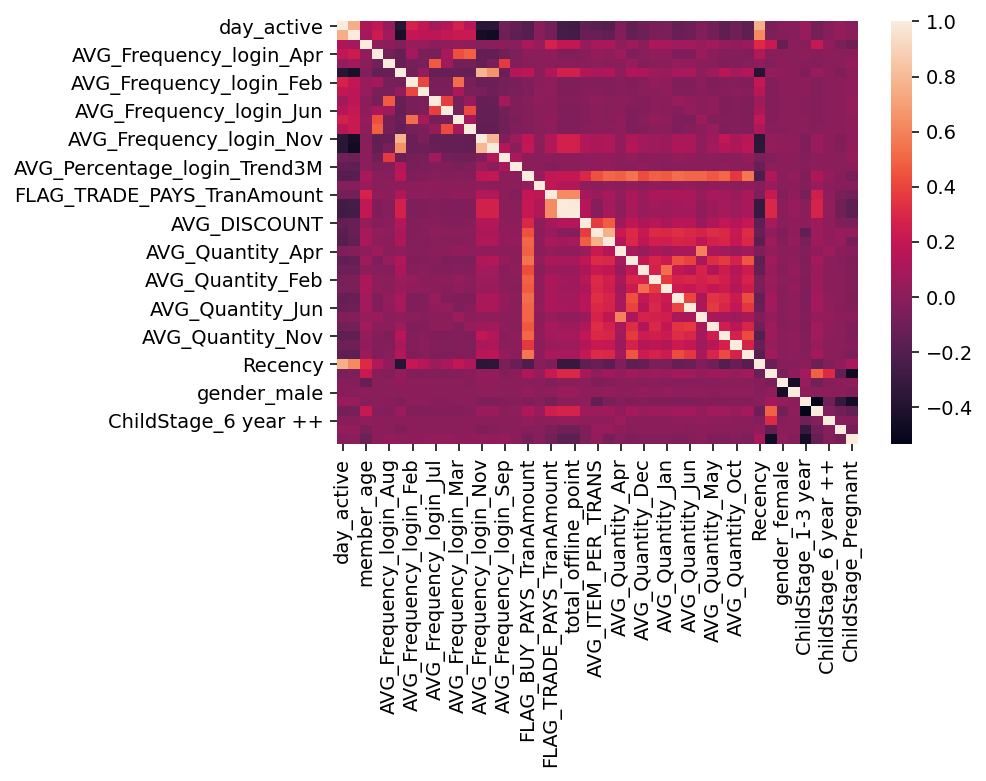

<matplotlib.axes._subplots.AxesSubplot at 0x7fd4bd706460>

In [0]:
sns.heatmap(itemData_final.corr())

In [0]:
cph = CoxPHFitter(alpha=0.05)
cph.fit(itemData_final, duration_col='day_active', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 68500 total observations, 29172 right-censored observations>
 duration col = 'day_active'
 event col = 'Churn'
 baseline estimation = breslow
 number of observations = 68500
number of events observed = 39328
 partial log-likelihood = -353239.47
 time fit was run = 2021-05-05 13:06:21 UTC

---
 coef exp(coef) se(coef) coef lower 95% coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate 
member_age 0.00 1.00 0.00 0.00 0.00 1.00 1.00
AVG_Frequency_login_Apr -0.01 0.99 0.00 -0.01 -0.00 0.99 1.00
AVG_Frequency_login_Aug -0.01 0.99 0.00 -0.01 -0.00 0.99 1.00
AVG_Frequency_login_Dec 0.01 1.01 0.00 0.01 0.02 1.01 1.02
AVG_Frequency_login_Feb -0.02 0.98 0.00 -0.03 -0.02 0.97 0.98
AVG_Frequency_login_Jan -0.05 0.95 0.00 -0.05 -0.04 0.95 0.96
AVG_Frequency_login_Jul 0.02 1.02 0.00 0.01 0.02 1.01 1.02
AVG_Frequency_login_Jun 0.00 1.00 0.00 -0.00 0.01 1.00 1.01
AVG_Frequency_login_Mar -0.02 0.98 0.00 -0.03 -0.02 0.97 0.98
AVG_Frequency_login_May 0.00 1.00 0.00 -0.00 0.01 1.00 1.01
AVG_Frequency_login_Nov -0.01 0.99 0.00 -0.01 -0.00 0.99 1.00
AVG_Frequency_login_Oct -0.04 0.96 0.00 -0.05 -0.03 0.96 0.97
AVG_Frequency_login_Sep 0.05 1.05 0.00 0.04 0.06 1.05 1.06
AVG_Percentage_login_Trend3M -0.03 0.97 0.01 -0.04 -0.02 0.96 0.98
FLAG_BUY_PAYS_TranAmount -0.00 1.00 0.00 -0.00 -0.00 1.00 1.00
FLAG_TRADE_ABANDON_TranAmount 0.00 1.00 0.00 -0.00 0.00 1.00 1.00
FLAG_TRADE_PAYS_TranAmount 0.00 1.00 0.00 0.00 0.00 1.00 1.00
count_offline_coupon -0.01 0.99 0.00 -0.01 -0.00 0.99 1.00
total_offline_point 0.00 1.00 0.00 0.00 0.00 1.00 1.00
AVG_DISCOUNT -0.00 1.00 0.00 -0.00 0.00 1.00 1.00
AVG_ITEM_PER_TRANS 0.03 1.03 0.01 0.01 0.06 1.01 1.06
AVG_Price_PER_TRANS 0.00 1.00 0.00 0.00 0.00 1.00 1.00
AVG_Quantity_Apr 0.01 1.01 0.00 0.01 0.02 1.01 1.02
AVG_Quantity_Aug 0.03 1.03 0.01 -0.00 0.05 1.00 1.05
AVG_Quantity_Dec -0.02 0.98 0.02 -0.06 0.02 0.94 1.02
AVG_Quantity_Feb 0.04 1.04 0.01 0.02 0.07 1.02 1.07
AVG_Quantity_Jan 0.05 1.05 0.01 0.03 0.07 1.03 1.08
AVG_Quantity_Jul 0.05 1.05 0.01 0.02 0.08 1.02 1.08
AVG_Quantity_Jun 0.04 1.05 0.01 0.02 0.07 1.02 1.07
AVG_Quantity_Mar 0.00 1.00 0.00 -0.01 0.01 0.99 1.01
AVG_Quantity_May 0.00 1.00 0.01 -0.01 0.02 0.99 1.02
AVG_Quantity_Nov 0.01 1.01 0.02 -0.02 0.05 0.98 1.05
AVG_Quantity_Oct 0.03 1.03 0.01 0.01 0.06 1.01 1.06
AVG_Quantity_Sep 0.01 1.01 0.01 -0.02 0.03 0.98 1.03
Recency -0.01 0.99 0.00 -0.01 -0.01 0.99 0.99
ChildStage_month 0.00 1.00 0.00 -0.00 0.00 1.00 1.00
gender_female 0.11 1.11 0.02 0.06 0.15 1.06 1.17
gender_male 0.18 1.20 0.06 0.07 0.29 1.07 1.33
ChildStage_1-3 year -0.12 0.89 0.02 -0.17 -0.08 0.85 0.93
ChildStage_3-6 year -0.20 0.82 0.03 -0.27 -0.14 0.76 0.87
ChildStage_6 year ++ -0.18 0.84 0.09 -0.36 0.00 0.70 1.00
ChildStage_7-12 month -0.10 0.90 0.03 -0.16 -0.04 0.85 0.96
ChildStage_Pregnant 0.18 1.19 0.03 0.12 0.23 1.13 1.26

 z p -log2(p)
covariate 
member_age 30.81 <0.005 690.08
AVG_Frequency_login_Apr -3.96 <0.005 13.73
AVG_Frequency_login_Aug -3.48 <0.005 10.97
AVG_Frequency_login_Dec 3.62 <0.005 11.74
AVG_Frequency_login_Feb -8.77 <0.005 58.96
AVG_Frequency_login_Jan -16.94 <0.005 211.42
AVG_Frequency_login_Jul 7.52 <0.005 44.08
AVG_Frequency_login_Jun 1.14 0.25 1.99
AVG_Frequency_login_Mar -11.31 <0.005 96.03
AVG_Frequency_login_May 0.83 0.41 1.29
AVG_Frequency_login_Nov -2.68 0.01 7.09
AVG_Frequency_login_Oct -11.63 <0.005 101.49
AVG_Frequency_login_Sep 18.22 <0.005 244.11
AVG_Percentage_login_Trend3M -4.40 <0.005 16.50
FLAG_BUY_PAYS_TranAmount -4.65 <0.005 18.23
FLAG_TRADE_ABANDON_TranAmount 1.00 0.32 1.65
FLAG_TRADE_PAYS_TranAmount 4.57 <0.005 17.62
count_offline_coupon -4.22 <0.005 15.30
total_offline_point 4.71 <0.005 18.64
AVG_DISCOUNT -0.61 0.54 0.89
AVG_ITEM_PER_TRANS 2.81 0.01 7.64
AVG_Price_PER_TRANS 6.06 <0.005 29.44
AVG_Quantity_Apr 3.98 <0.005 13.83
AVG_Quantity_Aug 1.81 0.07 3.83
AVG_Quantity_Dec -1.15 0.25 2.00
AVG_Quantity_Feb 3.37 <0.005 10.37
AVG_Quantity_Jan 4.03 <0.005 14.15
AVG_Quantity_Jul 3.74 <0.005 12.40
AVG_Quant

In [0]:
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#data_num2_std = data_num2.drop(columns=['ChildStage_month','Churn','day_active']) ## เลือก Data ที่จะมาทำ PCA 
## อันดับแรกต้อง Scaling Data ให้อยู่ในฐานเดียวกันก่อน

#sc = StandardScaler()
#Z = sc.fit_transform(data_num2_std)
## Finding n_component
#pca = PCA().fit(Z)
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.xlabel('number of components')
#plt.ylabel('cumulative explained variance')
## Use PCA 
#pca_apply = PCA(n_components=20)
#pca_apply.fit(Z)
#pca_data = pca_apply.fit_transform(Z)

In [0]:
#len(pca_apply.components_)

In [0]:
#pca_df = pd.DataFrame(data = pca_data
#             , columns = (['Component_{}'.format(x) for x in range(1, int(pca_data.shape[1])+1)]))
#
#pca_df.head()

In [0]:
## Invert Transform
#pd.DataFrame(sc.inverse_transform(pca_apply.inverse_transform(pca_data)),
#             columns=data_num2_std.columns)

In [0]:
#itemData_final_2_1 = itemData_final_2[itemData_final_2.columns.drop(data_num2_std.columns)]\
 #                                     .merge(pca_df, left_index=True, right_index=True)

In [0]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#create feature set and labels

X = itemData_final_2.drop(['id','Churn','day_active','ChildStage_month','AVG_Percentage_login_Trend3M'],axis=1) #old
y = itemData_final_2.Churn
#train and test splitิ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

In [0]:
pd.crosstab(y_train,'count')

Out[42]:

col_0,count
Churn,
0.0,20493
1.0,27457


In [0]:
pd.crosstab(y_test,'count')

Out[43]:

col_0,count
Churn,
0.0,8679
1.0,11871


###4.2  Build With Xgboost Classifier Start

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

In [0]:
#building the model & printing the score
with mlflow.start_run(run_name='xgboosting'):
  xgb_model = xgb.XGBClassifier(max_depth=10, learning_rate=0.01, objective= 'binary:logistic',n_jobs=-1,reg_lambda= 0.05,n_estimators= 500)
  xgb_model.fit(X_train, y_train)
  
  predictions_test = xgb_model.predict_proba(X_test)[:,1]
  
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_metric('auc', auc_score)
  # Use the area under the ROC curve as a metric.
  
  trainset_accuracy = xgb_model.score(X_train, y_train)
  mlflow.log_metric('training set', trainset_accuracy)

  testset_accuracy = xgb_model.score(X_test[X_train.columns], y_test)
  mlflow.log_metric('test set', testset_accuracy)
  

  wrappedModel = SklearnModelWrapper(xgb_model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  mlflow.pyfunc.log_model("xgboosting_model", python_model=wrappedModel, signature=signature)

In [0]:
#print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_model.score(X_train, y_train)))
#print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_model.score(X_test[X_train.columns], y_test)))
#from xgboost import plot_importance
#fig, ax = plt.subplots(figsize=(7,10))
#plot_importance(xgb_model, ax=ax , importance_type= 'weight')  # weight = is the number of times a feature appears in a tree

#####4.2.1 RegisterModel MLflow

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "xgboosting"').iloc[0].run_id

In [0]:
model_name = "churn_prediction"
model_version = mlflow.register_model(f"runs:/{run_id}/xgboosting_model", model_name)

In [0]:
### Save XGBoost Model Manual
#xgb_model.save_model(path_model+ 'model_churn_xgoost_2.model')

###4.3 Build With RandomforestClassifier

####4.3.1 Tunning Model XGB


In [0]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, STATUS_FAIL, space_eval
from hyperopt.pyll import scope
from math import exp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# define search space

#search_space = {
#    'n_estimators': hp.choice('n_estimators', np.arange(10, 1000, dtype=int)),
#    'max_depth': hp.choice('max_depth', np.arange(2, 8, dtype=int)),
#    'max_leaf_nodes': hp.choice('max_leaf_nodes', np.arange(2, 65, dtype=int)),
#    'scoring': 'f1_micro',
#    'cv': StratifiedKFold(n_splits=10)
#}

search_space = {
 'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(50, 1000, 10)),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}


# define function for model evaluation
def evaluate_model(params):
    mlflow.xgboost.autolog()
    with mlflow.start_run(nested=True):
      train = xgb.DMatrix(data=X_train, label=y_train)
      test = xgb.DMatrix(data=X_test, label=y_test)
      booster = xgb.train(params=params, dtrain=train,
                          num_boost_round=1000,\
                    evals=[(test, "test")], early_stopping_rounds=50)
  
      predictions_test = booster.predict(test) 
      auc_score = roc_auc_score(y_test, predictions_test)
      mlflow.log_metric('auc', auc_score)
      
      
      
      signature = infer_signature(X_train, booster.predict(train))
      mlflow.xgboost.log_model(booster, "model", signature=signature)


  # return score and status
      return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

In [0]:
# configure hyperopt settings to distribute to all executors on workers
spark_trials = SparkTrials(parallelism=10)

# select optimization algorithm
algo = tpe.suggest

# perform hyperparameter tuning (logging iterations to mlflow)
argmin = fmin(
  fn=evaluate_model,
  space=search_space,
  algo=algo,
  max_evals=30,
  trials=spark_trials,
  verbose=True
  )


Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [00:30<14:38, 30.30s/trial, best loss: -0.9651460841252048] 7%|▋ | 2/30 [00:56<13:33, 29.06s/trial, best loss: -0.9857147459202248] 13%|█▎ | 4/30 [00:58<08:56, 20.64s/trial, best loss: -0.9857147459202248] 17%|█▋ | 5/30 [01:20<08:46, 21.06s/trial, best loss: -0.9857147459202248] 20%|██ | 6/30 [01:22<06:09, 15.39s/trial, best loss: -0.9898331925129504] 23%|██▎ | 7/30 [01:28<04:49, 12.58s/trial, best loss: -0.9898331925129504] 27%|██▋ | 8/30 [01:33<03:47, 10.34s/trial, best loss: -0.9924147523233131] 30%|███ | 9/30 [01:54<04:44, 13.55s/trial, best loss: -0.9924147523233131] 33%|███▎ | 10/30 [02:00<03:45, 11.29s/trial, best loss: -0.9924147523233131] 37%|███▋ | 11/30 [02:06<03:04, 9.71s/trial, best loss: -0.9924147523233131] 40%|████ | 12/30 [02:08<02:13, 7.41s/trial, best loss: -0.9924147523233131] 43%|████▎ | 13/30 [02:10<01:38, 5.80s/trial, best loss: -0.9924147523233131] 50%|█████ | 15/30 [02:30<01:43, 6.92s/trial, best loss: -0.9924147523233131] 53%|█████▎ | 16/30 [02:54<02:48, 12.07s/trial, best loss: -0.9924147523233131] 57%|█████▋ | 17/30 [02:57<02:01, 9.36s/trial, best loss: -0.9924147523233131] 60%|██████ | 18/30 [03:10<02:05, 10.47s/trial, best loss: -0.9924147523233131] 63%|██████▎ | 19/30 [03:21<01:57, 10.64s/trial, best loss: -0.9924147523233131] 67%|██████▋ | 20/30 [03:40<02:11, 13.16s/trial, best loss: -0.9924147523233131] 70%|███████ | 21/30 [03:43<01:31, 10.12s/trial, best loss: -0.9924147523233131] 73%|███████▎ | 22/30 [04:08<01:56, 14.59s/trial, best loss: -0.9924147523233131] 77%|███████▋ | 23/30 [04:11<01:17, 11.11s/trial, best loss: -0.9924147523233131] 80%|████████ | 24/30 [04:15<00:53, 8.98s/trial, best loss: -0.9924147523233131] 83%|████████▎ | 25/30 [04:33<00:58, 11.73s/trial, best loss: -0.9931324281635758] 87%|████████▋ | 26/30 [04:34<00:34, 8.51s/trial, best loss: -0.9931324281635758] 90%|█████████ | 27/30 [05:20<00:59, 19.77s/trial, best loss: -0.9931324281635758] 93%|█████████▎| 28/30 [05:46<00:43, 21.65s/trial, best loss: -0.9931324281635758] 97%|█████████▋| 29/30 [06:02<00:19, 19.96s/trial, best loss: -0.9931324281635758]100%|██████████| 30/30 [06:40<00:00, 25.38s/trial, best loss: -0.9931324281635758]100%|██████████| 30/30 [06:40<00:00, 13.35s/trial, best loss: -0.9931324281635758]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

In [0]:
# Get Best Param
print(space_eval(search_space, argmin))

{'colsample_bytree': 0.5700000000000001, 'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 10.0, 'n_estimators': 860, 'reg_lambda': 0.3738743864406947, 'subsample': 0.67}

In [0]:
# get hyperparameter settings
params = space_eval(search_space, argmin)

colsample_bytree_params = params['colsample_bytree']
learning_rate_params = params['learning_rate']
max_depth_params = params['max_depth']
min_child_weight_params = params['min_child_weight']
n_estimators_params = params['n_estimators']
reg_lambda_params = params['reg_lambda']
subsample_params = params['subsample']


#model_rf_after = RandomForestClassifier(max_depth=max_depth_param , n_estimators = n_estimators_param , max_leaf_nodes=max_leaf_nodes_param)
model_xgb_after = xgb.XGBClassifier(max_depth = max_depth_params, 
                                    learning_rate=learning_rate_params, 
                                    objective= 'binary:logistic',n_jobs=-1,
                                    reg_lambda= reg_lambda_params,
                                    n_estimators= n_estimators_params,
                                   colsmaple_bytree =colsample_bytree_params)
model_xgb_after.fit(X_train, y_train)


best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')
# Use the area under the ROC curve as a metric.


testset_accuracy = model_xgb_after.score(X_test[X_train.columns], y_test)
print('test set accuracy : ' ,testset_accuracy )
mlflow.log_metric('test set accuracy ', testset_accuracy)


/databricks/python/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
 warnings.warn(label_encoder_deprecation_msg, UserWarning)
[12:55:41] WARNING: ../src/learner.cc:541: 
Parameters: { colsmaple_bytree } might not be used.

 This may not be accurate due to some parameters are only used in language bindings but
 passed down to XGBoost core. Or some parameters are not used but slip through this
 verification. Please open an issue if you find above cases.


[12:55:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC of Best Run: 0.9934123558095516
test set accuracy : 0.9530900243309003

In [0]:
pd.DataFrame({'Feature':X_train.columns,
              'Score':model_xgb_after.feature_importances_})\
  .sort_values(by='Score', ascending=False)\
  .head(50)

Out[54]:

,Feature,Score
11,AVG_Frequency_login_Oct,0.373342
34,Recency,0.117149
5,AVG_Frequency_login_Jan,0.086531
10,AVG_Frequency_login_Nov,0.072246
3,AVG_Frequency_login_Dec,0.059807
4,AVG_Frequency_login_Feb,0.023699
43,ChildStage_Pregnant,0.021584
8,AVG_Frequency_login_Mar,0.012488
2,AVG_Frequency_login_Aug,0.012485
38,ChildStage_0-6 month,0.010102


In [0]:
y_pred = model_xgb_after.predict(X_test)
print(classification_report(y_test, y_pred))

precision recall f1-score support

 0.0 0.95 0.94 0.94 8679
 1.0 0.96 0.96 0.96 11871

 accuracy 0.95 20550
 macro avg 0.95 0.95 0.95 20550
weighted avg 0.95 0.95 0.95 20550

In [0]:
pd.DataFrame({'Feature':X_train.columns,
              'Score':model_xgb_after.feature_importances_})\
  .sort_values(by='Score', ascending=False)\
  .to_pickle('/dbfs/FileStore/feature_importance_XGB_draft1.data')

In [0]:
import pickle
pickle.dump(model_xgb_after, open(path_model+"model_churn_draft_xgoost_V1.model.dat", "wb"))
# save the model  Manual